In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
import pickle
from tqdm.notebook import tqdm
import string
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Road_caption'
WORKING_DIR = './'
img_path = '/content/drive/MyDrive/Road_caption/RoadImages1'
cap_path = '/content/drive/MyDrive/Road_caption/RoadImageCaption.txt'

In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#print(model.summary())

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'RoadImages1')

for img_name in tqdm(os.listdir(directory)):
    # load image
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID (file img non .jpg)
    image_id = img_name.split('.')[0]

    features[image_id] = feature


  0%|          | 0/2252 [00:00<?, ?it/s]

In [ ]:
with open(os.path.join('/content/drive/MyDrive/Road_caption/RoadImageCaption.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(' # ')

    try:
        image_id, caption = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        caption = " ".join(caption)
    except:
        caption = np.nan

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('.', '')
            caption = caption.replace('\s+', ' ')
            caption = caption.replace('\d+', '')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# Pre-processing
clean(mapping)

In [ ]:
img_filename = []

for f in os.listdir('/content/drive/MyDrive/Road_caption/RoadImages1'):
    img_filename.append((f.split('.'))[0])

In [ ]:
len(mapping)

2000

In [ ]:
# Find intersection set
intersection = set(img_filename) & set(mapping.keys())

In [ ]:
# Collect all captions in mapping into list all_captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

2000

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

3

In [ ]:
# Maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

2

In [ ]:
#test train split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

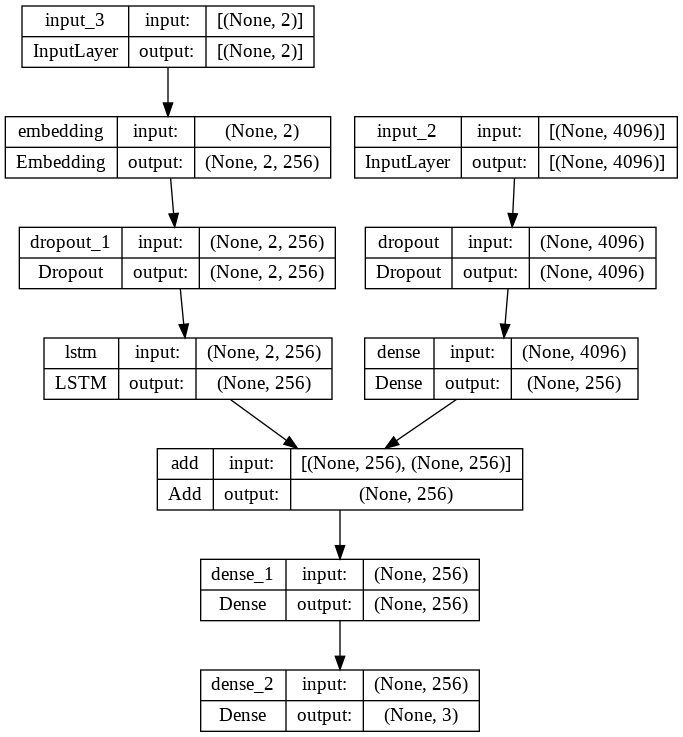

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [ ]:
# Train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

# Create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit model
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [ ]:
# Save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'

    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += " " + word
        # Stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

In [ ]:
# BLEU score
from nltk.translate.bleu_score import corpus_bleu

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))